# Segmentation

In [2]:
import sys
sys.path.append('/home/commun/tp-morpho/')
from tp_init import *

## Binary segmentation

This exercise shows step by step the classical binary segmentation algorithm. The left hand column shows the original image, the middle one its distance function, and the right hand image is the watershed of the inverse distance function where some coffee grains have been over-segmented (due to countour irregularities).


Computing distance function
Computing watershed of inverse distance function:


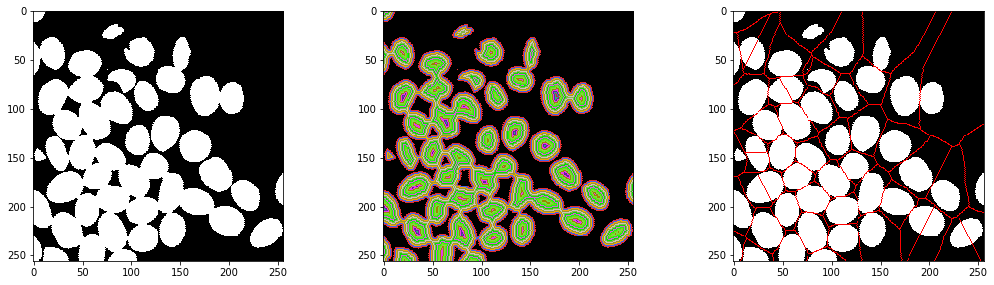

In [2]:

# Load input image
im=Image(images_dir+"/Bin/coffee.png")

##Initializes the intermediate images    
imStrech,imDistance,imDisInvert,imWs,imdisp=Image(im),Image(im),Image(im),Image(im),Image(im)

# Set connexity
nl=HexSE()

##Computes the distance function
print ("Computing distance function")
dist(im,imDistance,nl)

##Compute watershed of inverse Distance function
print ("Computing watershed of inverse distance function:")

inv(imDistance,imDisInvert)
watershed(imDisInvert,imWs, nl)

#compare(imWs,"==",255,127,im,imdisp)
imdisp = colorHighlight(im, imWs, [255, 0, 0])

disp([im,imDistance,imdisp],[False,True,False])

We also display the maxima of the distance function with their labels, to see their connected components. As we can see, where the cells are split in two, several disconnected maxima are present.

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


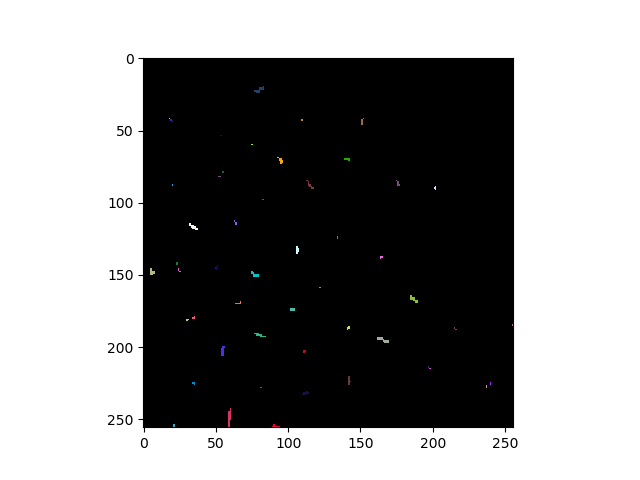

In [4]:
imMaxDist = Image(im)
maxima(imDistance, imMaxDist)
label(imMaxDist, imMaxDist)

dispI(imMaxDist, True)

Then we show the improvement after the h-maxima filtering of the distance function.

Remove low contrasted maxima: dynamic <= 2
Compute watershed in inverse Filter Distance function:


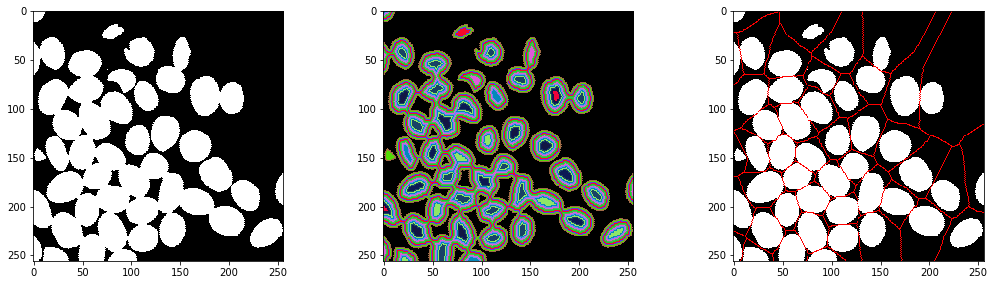

In [5]:
%matplotlib inline

def hMaximaFilter(im, h, imOut, nl):
    imtmp = Image(im)
    sub(im,h,imtmp)
    build(imtmp,im,imOut,nl)
    

##Filters distance function by HMaxima
##Parameters HMaxima
ThreshHeightMaxima=2
print ("Remove low contrasted maxima: dynamic <=",ThreshHeightMaxima)

imDistanceFilter = Image(imDistance)
hMaximaFilter(imDistance, ThreshHeightMaxima, imDistanceFilter, nl)
inv(imDistanceFilter,imDisInvert)

##Computes watershed of inverse Filter distance function
print ("Compute watershed in inverse Filter Distance function:")

watershed(imDisInvert,imWs,nl)
#compare(imWs,"==",255,127,im,imdisp)
imdisp = colorHighlight(im, imWs, [255, 0, 0])

disp([im,imDistanceFilter,imdisp],[False,True,False])

<IPython.core.display.Javascript object>


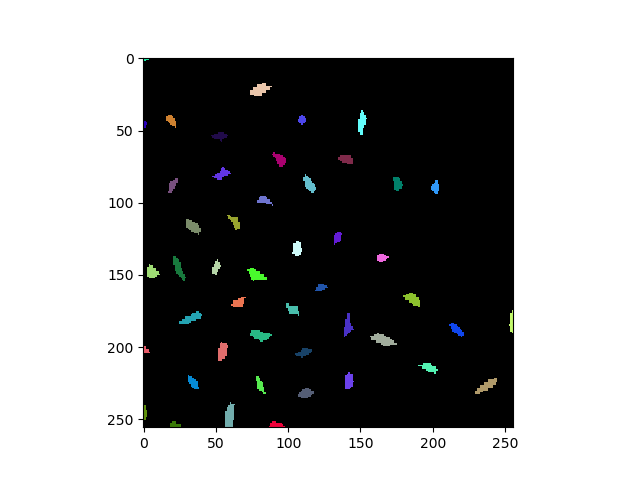

In [6]:
%matplotlib notebook
imMaxDist = Image(im)
maxima(imDistanceFilter, imMaxDist)
label(imMaxDist, imMaxDist, nl)

dispI(imMaxDist, True)

## DNA Segmentation

In this exercise we see how to introduce markers into the segmentation process. 

First the original image is filtered by an areaOpen, in order to remove noise. The maxima of the filtered image (c) are used as inner markers. Then we need an outer marker in order to flood the background and find the contour between the object and its background. The watershed of the inverse image (not of its gradient) from inner markers is used as outer marker. Other choices such as a threshold may also be considered. Finally the watershed of the gradient image from the union of inner and outer marker is performed. The cell contours are detected correctly. Coffee grains separation can be applied in order to separate connected cells.


maxima on original (top) and filtered (bottom) images


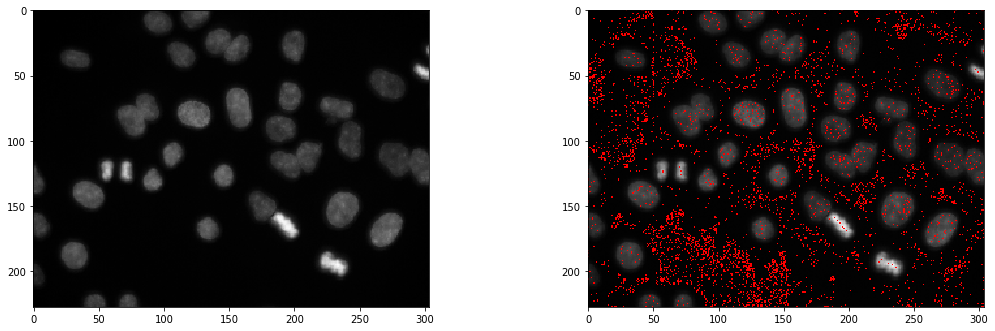

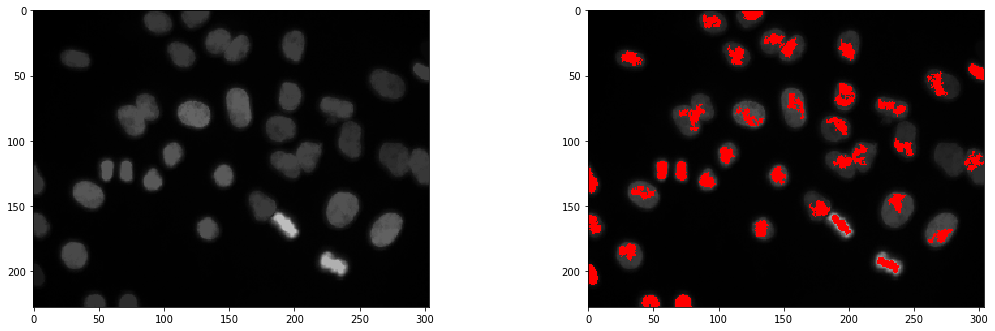

In [7]:
%matplotlib inline

im = Image(images_dir+"/Gray/DNA_small.png")

# Initializes intermediate images      
imgra,imfil,imtmp,immax,immark_in,immark_out,immark = Image(im),Image(im),Image(im),Image(im),Image(im),Image(im),Image(im)

imtmp2,imws = Image(im),Image(im)

nl = HexSE()

"""
STEP 1: We determine the regional maxima of the image. To reduce the
number of maxima, we can filter the image.
"""

# Filtering
hfilter=False #True
areafilter=not hfilter
if(areafilter):
    filter_size = 100
    areaOpen(im,filter_size,imfil,nl) 
else:
    open(im,imtmp,nl(3))
    hBuild(imtmp,2,imfil,nl)

# Maxima without filtering
maxima(im, immax, nl)
immaxRed = colorHighlight(im, immax)


# Maxima after filtering
maxima(imfil,immax,nl)
immaxFilRed = colorHighlight(imfil, immax)

print("maxima on original (top) and filtered (bottom) images")
disp([im,immaxRed])
disp([imfil,immaxFilRed])


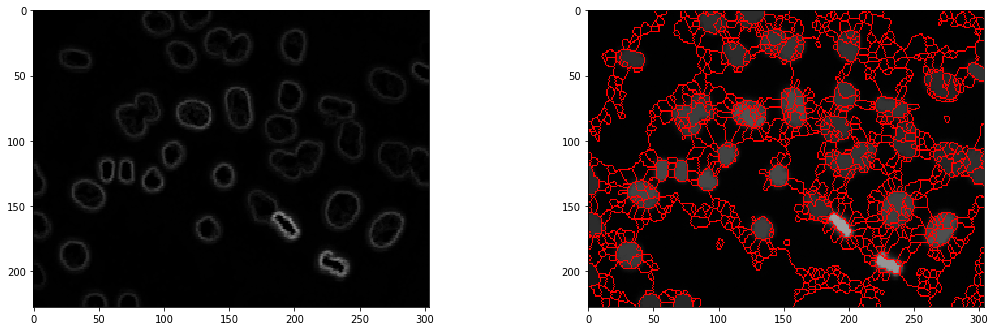

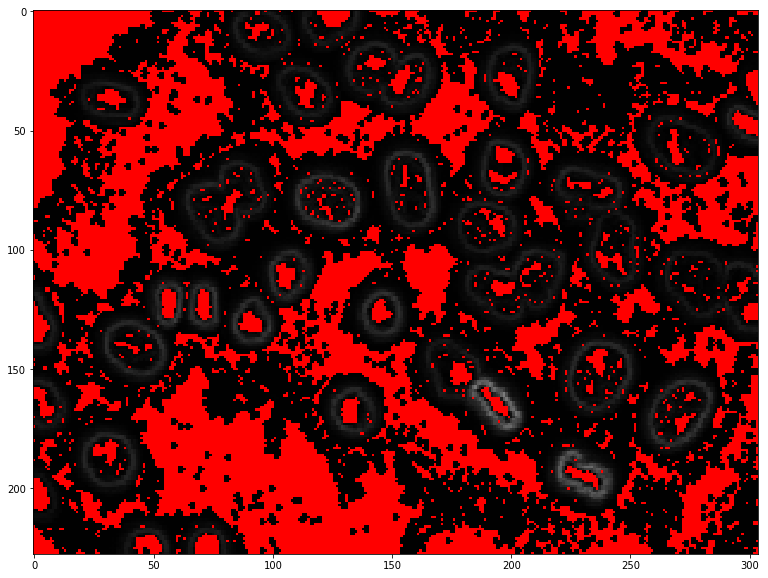

In [8]:
"""
STEP 2: We compute the morphological gradient and the watershed of the gradient.
This results in an oversegmentation of the input image
"""

gradient(imfil, imgra, nl)
watershed(imgra, imws, nl)
imWsRed = colorHighlight(imfil, imws)

immin = Image(imgra)
minima(imgra, immin)
imminRed = colorHighlight(imgra, immin)

disp([imgra, imWsRed])
disp(imminRed)


number of cells 35


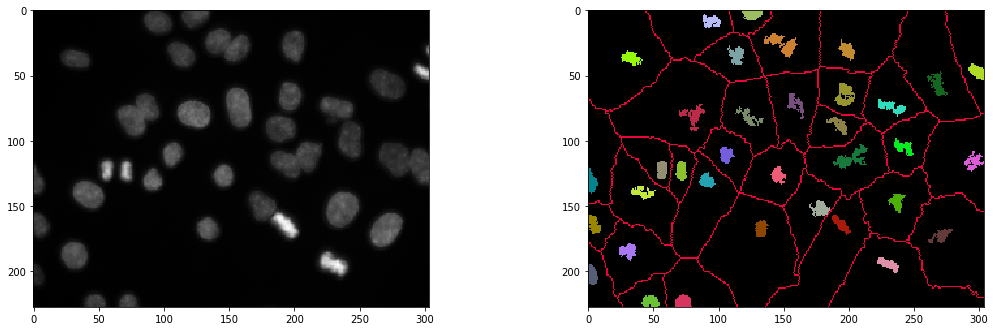

Original image, inner and external markers.


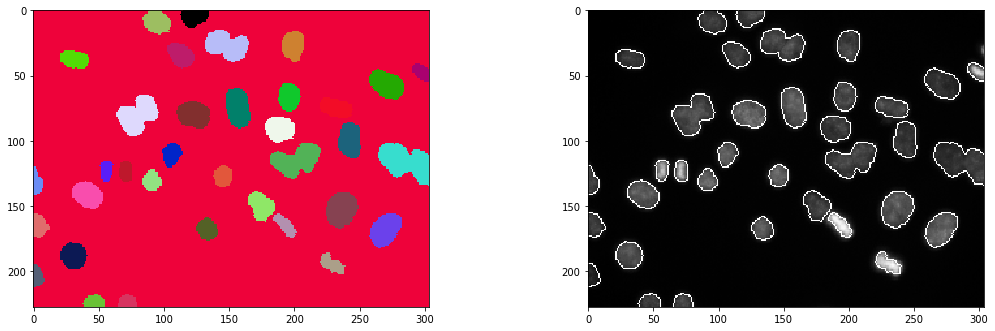

Basins and watershed obtained by the watershed from markers algorithm.


In [9]:
"""
STEP 3: Watershed from markers
"""

label(immax,immark_in,nl) # inner marker
nb_cells = maxVal(immark_in)
print("number of cells",nb_cells)
if(nb_cells > 255):
    print ("WARNING: more than 255 minima, 16 bits images required")
    
    
# External marker: we apply the watershed to the inverse of the original image to get external markers
inv(imfil,imtmp)
watershed(imtmp,imws,nl)
 
# external marker with its corresponding label
compare(imws,"==",255,nb_cells+1,0,immark_out) 
    
# union of inner and external marker
sup(immark_in,immark_out,immark) # union of inner and external marker
    
# watershed from markers
imbasins = Image(immark)
watershed(imgra,immark,imws,imbasins,nl)
    
compare(imws,"==",255,255,im,imtmp)
  
disp([im,immark],[False,True])
print("Original image, inner and external markers.")
disp([imbasins,imtmp],[True,False])
print("Basins and watershed obtained by the watershed from markers algorithm.")

## Relief

The image "/Gray/relief.png" represents an image of topological relief, where each pixel value corresponds to an elevation. We are looking for the watershed line between the top right and bottom left rivers. We may think that applying the watershed transformation directly is sufficient, but due to image noise we have an over-segmentaion.

Assuming that relevant minima are rivers that touch the image border and that there are no lake included in the image, noisy minima can be removed using FillHoles transformation on the original image. Applying the ws transform on the filtered image, we get rid of many useless contours.


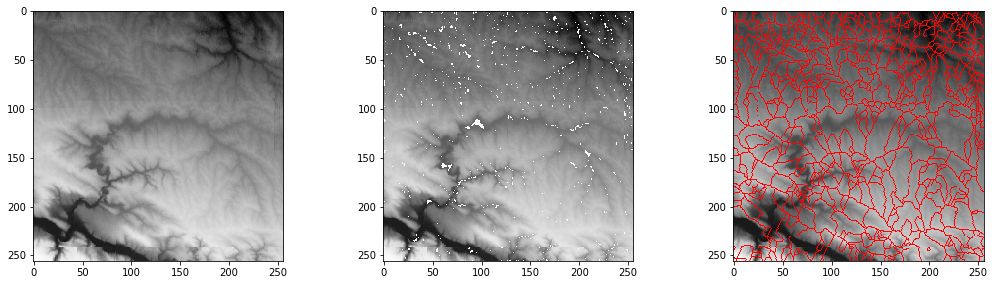

In [10]:
%matplotlib inline
# Load input image
im=Image(images_dir+"/Gray/relief.png")
    
## Initialize all intermediate images   
imCloseHoles,imWs,imDisp=Image(im),Image(im),Image(im)

## Chooses the graph connexity
nl=HexSE()

###############
## Ws of the relief original image
###############
    
watershed(im,imWs,nl)

##Show minima and WsLines
immin = Image(im)
minima(im, immin)
sup(im, immin, immin)
imWsRed = colorHighlight(im, imWs)
disp([im,immin, imWsRed])

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


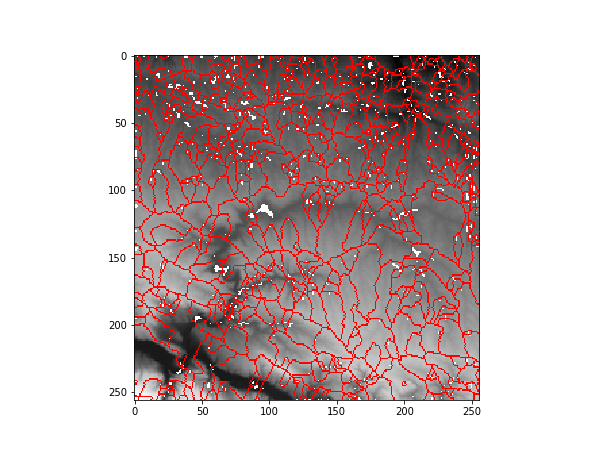

In [14]:
##Show minima and WsLines in same image   
imWsRed = colorHighlight(immin, imWs)
dispI(imWsRed)

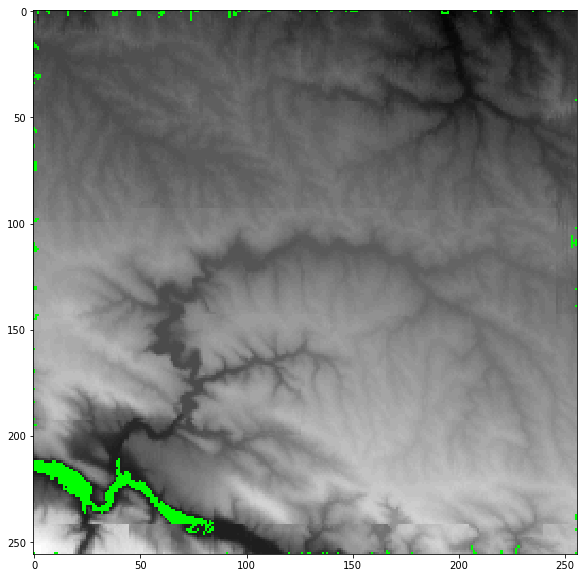

No minima inside center of the image, all basins touch the border


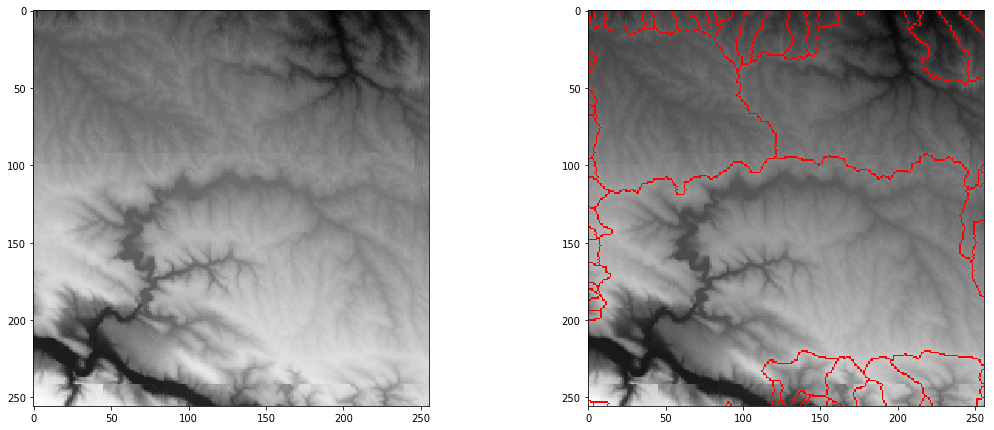

Fill-holes image and its watershed.


In [15]:
%matplotlib inline
###############
## FillHoles (only minima touching the image border remain)
###############

fillHoles(im,imCloseHoles,nl)

###############
## ws on the filtered image
###############
watershed(imCloseHoles,imWs,nl)
#sup(imWs,im,imDisp)
imFWsRed = colorHighlight(imCloseHoles, imWs)

imMinima=Image(im)
minima(imCloseHoles,imMinima,nl)
imminGreen = colorHighlight(imCloseHoles, imMinima, [0, 255, 0])
disp(imminGreen)
print ("No minima inside center of the image, all basins touch the border" )

disp([imCloseHoles,imFWsRed])
print ("Fill-holes image and its watershed.")


## Waterfall
The Waterfall is a Watershed-based hierarchical segmentation
approach. It consists in two steps:

1. First, each region is filled with the value of the lowest pass point of its frontier. The pass point is the pixel where, during the flooding process associated with the Watershed, neighbouring lakes (regions) meet for the first time. A morphological reconstruction (dualBuild) may be used for this purpose.
 
2. Second, the Watershed of the resulting image is computed.

The process may be iterated until a single region covers the whole image, establishing a hierarchy among the frontiers produced by the Watershed. An efficient graph-based waterfall algorithm also exists.

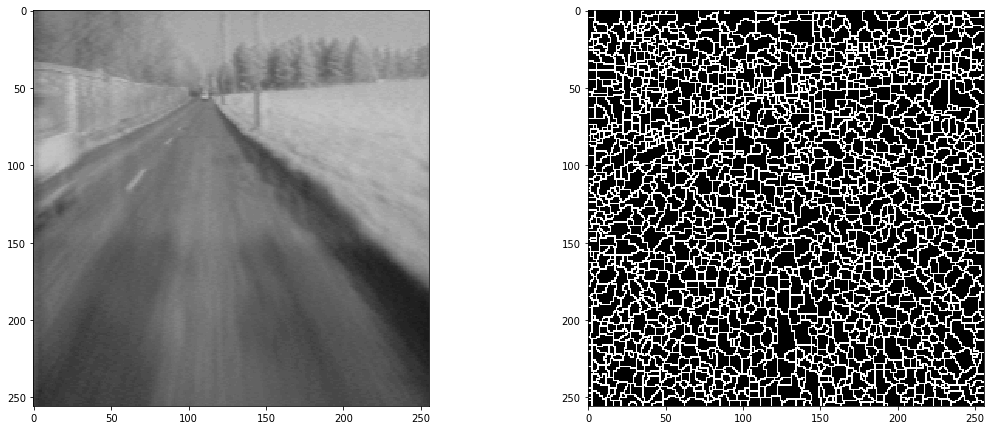

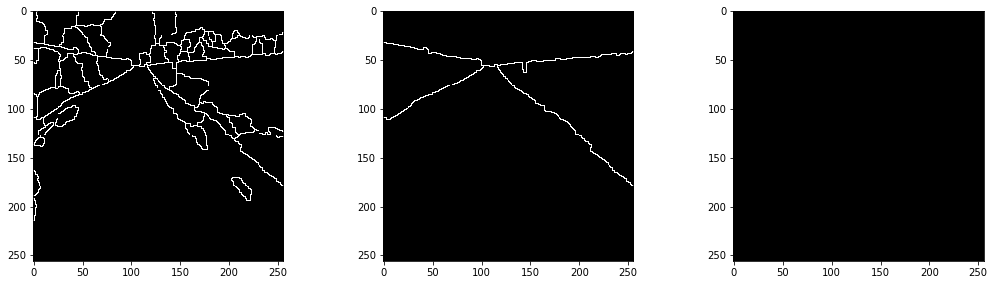

In [3]:
def ImWaterfalls(imgra,imws0,imws1,nl):
    imtmp = Image(imgra)
    compare(imws0,">",0,imgra,255,imtmp)
    dualBuild(imtmp,imgra,imws1,nl)
    copy(imws1,imgra)
    watershed(imgra,imws1,nl)

# Load input image
im = Image(images_dir+"/Gray/road.png")
imgra = Image(im)
#imtmp = Image(im)
imws0,imws1,imws2,imws3 = Image(im),Image(im),Image(im),Image(im)


# Structuring element
nl=SquSE()

## Segmentation with the waterfall algorithm
gradient(im,imgra,nl)
watershed(imgra,imws0,nl)

ImWaterfalls(imgra,imws0,imws1,nl)

ImWaterfalls(imgra,imws1,imws2,nl)
ImWaterfalls(imgra,imws2,imws3,nl)

disp([im,imws0])
disp([imws1,imws2,imws3])
